In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import astropy.constants as c
import astropy.units  as u

## you can undo the lines below (but it will be fun for making fancy plots!)
# to make the lines below work, you have to download the file 'PostProcessingScripts' from https://github.com/FloorBroekgaarden/common_code
# and put this in the same directory as this one, and then only use the bottom line from this code below 
import sys
sys.path.append('../../common_code') 
# from PostProcessingScripts import * 

# to make the screen wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:

# import GROWL catalog info 
sys.path.append('/Users/floorbroekgaarden/Projects/GitHub/GROWL-catalog-public/growl_common_code') 
from growl_catalog import *
from common_functions import *



In [15]:
# Assuming you have the GROWL catalog from the previous artifact
growl_catalog = build_growl_catalog()
#print GROWL catalog possible entries
print_catalog_summary(growl_catalog)

GROWL Catalog Summary:

Author: Boesky24
  File: bps_output_BBH_pessimistic.h5
  Datasets (19):
    - alpha0_1beta0_25
    - alpha0_1beta0_5
    - alpha0_1beta0_75
    - alpha0_5beta0_25
    - alpha0_5beta0_5
    - alpha0_5beta0_75
    - alpha10_beta0_25
    - alpha10_beta0_5
    - alpha10_beta0_75
    - alpha2_beta0_5
    - alpha2beta0_25
    - sigma_265_RMP_Mandel
    - sigma_265_RMP_Rapid
    - sigma_30_RMP_Delayed
    - sigma_30_RMP_Mandel
    - sigma_30_RMP_Rapid
    - sigma_750_RMP_Delayed
    - sigma_750_RMP_Mandel
    - sigma_750_RMP_Rapid


### Example [you can skip this]: Plot Formation Efficiency for Boesky model

In [ ]:

# Assuming you have the GROWL catalog from the previous artifact
growl_catalog = build_growl_catalog()
#print GROWL catalog possible entries
print_catalog_summary(growl_catalog)

boesky_dataset_list =  list_datasets(growl_catalog, 'Boesky24')
print(boesky_dataset_list)




full_path = get_file_path(growl_catalog, "Boesky24", dataset="alpha0_1beta0_5")
df = pd.read_hdf(full_path, key="input_data")

# Inspect the available columns
print(df.columns)

formation_efficiency_per_solar_mass = df['formation_efficiency_per_solar_mass'].values
metallicities = df["metallicity"].values



# make a plot 

fs=18

hist, bin_edges = np.histogram(np.log10(metallicities/0.0142), weights=formation_efficiency_per_solar_mass, bins=50, density=True)

bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
normalization = np.sum(formation_efficiency_per_solar_mass)

plt.plot(bin_centers, hist*normalization, lw=3)


plt.yscale('log')
plt.ylim(10**-8, 10**-5)

plt.ylabel(r'Formation efficiency $\eta \ [M_{\odot}]$', fontsize=fs)
plt.xlabel(r'Metallicity $\log_{10}(Z/Z_{\odot})$', fontsize=fs)
plt.show()



## Set up  S(Z,z)

In [16]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union, Dict, List, Tuple, Optional
from dataclasses import dataclass
from pathlib import Path

import os
import json
import pkg_resources
import copy
import logging
import h5py

import copy
import logging
import pandas as pd
import sys

# sys.path.append('/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve')
sys.path.insert(0, '/Users/floorbroekgaarden/Projects/GitHub/syntheticstellarpopconvolve') # fixed this to import sspc in jupyter notebook for me 
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir

from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict

from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import temp_dir, generate_boilerplate_outputfile


In [32]:

# ------------------
# High-level driver
# ------------------

def process_dataset(growl_catalog, project_name, dataset, nbins=200, num_redshift_bins=100, sfr_plotting=False):
    """Run the full GROWL convolution processing pipeline for a single dataset."""
    # 1. Compute metallicity bins and SFR dictionary
    sfr_dict = setup_sfr_dict(
        growl_catalog, project_name, dataset,
        nbins=nbins, num_redshift_bins=num_redshift_bins
    )

    # 2. Plot SFR dictionary
    if sfr_plotting==True:
        plot_sfr(sfr_dict)

    # 3. Setup output file + copy input data
    output_hdf5_filename, output_hdf5_folder = setup_output_file(growl_catalog, project_name, dataset)

    copy_input_data_to_output(growl_catalog, project_name, dataset, output_hdf5_filename)

    # 4. Configure convolution
    convolution_config = setup_convolution_config(
        output_hdf5_filename, output_hdf5_folder, sfr_dict
    )

    # 5. Run convolution
    convolve(config=convolution_config)

    print(f"✅ Done processing dataset: {dataset}")


# ------------------
# Step 1: SFR + metallicity setup
# ------------------

def setup_sfr_dict(growl_catalog, project_name, dataset, nbins=200, num_redshift_bins=100, redshift_min=0, redshift_max=10):
    """Prepare metallicity and SFR distributions for a dataset."""
    full_path = get_file_path(growl_catalog, project_name, dataset=dataset)
    df = pd.read_hdf(full_path, key="input_data")

    # Metallicities
    metallicities = df["metallicity"].values
    _, log_metallicity_bin_edges = np.histogram(np.log(metallicities), bins=nbins, density=True)
    log_metallicity_bin_centers = (log_metallicity_bin_edges[:-1] + log_metallicity_bin_edges[1:]) / 2

    metallicity_bin_centers = np.exp(log_metallicity_bin_centers)
    metallicity_bin_edges = np.exp(log_metallicity_bin_edges)

    # Redshift bins
    redshift_bin_edges = np.linspace(redshift_min, redshift_max, num_redshift_bins)
    redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

    # Metallicity distribution
    dpdlogZ = metallicity_distribution_vanSon2022(
        log_metallicity_centers=log_metallicity_bin_centers,
        redshifts=redshift_bin_centers,
    )

    # SFR distribution
    sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

    return {
        "redshift_bin_edges": redshift_bin_edges,
        "starformation_rate_array": sfr,
        "metallicity_bin_edges": metallicity_bin_edges,
        "metallicity_distribution_array": (1/metallicity_bin_centers) * dpdlogZ,
    }


# ------------------
# Step 2: Plotting
# ------------------

def plot_sfr(sfr_dict):
    """Plot the SFR + metallicity distribution."""
    
    
    print(f"Making a plot of the S(Z,z) you are using as a sanity check")
    
    axis_dict = plot_sfr_dict(
        sfr_dict,
        time_type="redshift",
        metallicity_string="logZ",
        metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
        metallicity_distribution_multiply_by_sfr=False,
        metallicity_distribution_scale="log10",
        metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
        return_axis_dict=True,
        figsize=(8, 8),
        fontsize=12,
    )
    axis_dict['ax_mssfr'].set_yscale('log')
    axis_dict['ax_mssfr'].set_ylim([1e-5, 1])
    


# ------------------
# Step 3: Output file setup
# ------------------

def setup_output_file(growl_catalog, project_name, dataset):
    """Create boilerplate output file for convolution."""
    output_hdf5_folder = get_folder_path_convolution_output(growl_catalog, project_name, dataset=dataset)
    output_hdf5_filename = os.path.join(output_hdf5_folder, "sspc_output.h5")

    generate_boilerplate_outputfile(output_hdf5_filename)

    return output_hdf5_filename, output_hdf5_folder


def copy_input_data_to_output(growl_catalog, project_name, dataset, output_hdf5_filename):
    """Copy minimal required input data into the output file."""
    full_path = get_file_path(growl_catalog, project_name, dataset=dataset)
    df = pd.read_hdf(full_path, key="input_data")

    example_data = {
        "delay_time": df['delay_time'].values,
        "metallicity": df["metallicity"].values,
        "number_per_solar_mass_values": df['formation_efficiency_per_solar_mass'].values,
    }
    example_df = pd.DataFrame.from_records(example_data)
    example_df.to_hdf(output_hdf5_filename, key="input_data/growl")


# ------------------
# Step 4: Convolution config
# ------------------

def setup_convolution_config(output_hdf5_filename, output_hdf5_folder, sfr_dict):
    """Prepare the convolution configuration dictionary."""
    convolution_config = copy.copy(default_convolution_config)
    convolution_config['logger'].setLevel(logging.WARNING)

    convolution_config["redshift_interpolator_data_output_filename"] = os.path.join(
        output_hdf5_folder, "interpolator_dict.p"
    )
    convolution_config["multiply_by_time_binsize"] = False
    convolution_config["time_type"] = "redshift"
    convolution_config["output_filename"] = output_hdf5_filename

    convolution_config["convolution_instructions"] = [
        {
            **default_convolution_instruction,
            "convolution_type": "integrate",
            "input_data_name": "growl",
            "output_data_name": "intrinsic",
            "data_column_dict": {
                "normalized_yield": "number_per_solar_mass_values",
                "delay_time": {"column_name": "delay_time", "unit": u.Myr},
                "metallicity": "metallicity"
            },
        },
    ]

    # Here: only care about local universe
    convolution_config["convolution_redshift_bin_edges"] = np.array([0, 0.25])
    convolution_config["SFR_info"] = sfr_dict

    return convolution_config


# ------------------
# Example how to read this data 
# ------------------

# import h5py


## need to change this function to return any given parameter from the file. (not just primary)
def read_primary_mass_and_yields(growl_catalog, project_name, dataset, output_hdf5_filename, 
                                 redshift_key="0.125"):
    """
    Read primary masses from the original dataset and corresponding yield weights 
    from the convolution output file at a given redshift.

    Parameters
    ----------
    growl_catalog : object
        GROWL catalog object.
    project_name : str
        E.g. "Boesky24".
    dataset : str
        Dataset identifier, e.g. "alpha0_1beta0_5".
    convolution_config : dict
        Convolution configuration dictionary (after running `setup_convolution_config`).
    redshift_key : str, optional
        Redshift bin key in the HDF5 structure (default "0.125").
    mass_bins : array-like
        Bins for primary mass histogram (default np.arange(0, 80, 2)).

    Returns
    -------
    mass_primary : np.ndarray
        primary masses 
    yield_data : np.ndarray
        intrinsic rate of that binary at redshift provided by redshift_key in Gpc^-3 yr^-1
    """
    # ---- Step 1: read primary masses from original dataset
    full_path = get_file_path(growl_catalog, project_name, dataset=dataset)
    df = pd.read_hdf(full_path, key="input_data")

    mass_primary, mass_secondary = get_primary_secondary(
        df['dco_mass_1'].values, df['dco_mass_2'].values
    )

    # ---- Step 2: read yield_data from convolution output
    output_filename = output_hdf5_filename
    
    
    # can probably also use pd.read_hdf5 for this, but for now leaving as is 
    with h5py.File(output_filename, "r") as f:
        key = f"output_data/growl/intrinsic/convolution_results/{redshift_key}/"
        yield_data = f[key + "yield"][()]
        unit_dict = extract_unit_dict(f, key)  # optional

#     # ---- Step 3: bin primary masses weighted by yield_data
#     hist, _ = np.histogram(mass_primary, bins=mass_bins, weights=yield_data)
#     bin_centers = (mass_bins[:-1] + mass_bins[1:]) / 2

    return mass_primary, yield_data





In [27]:
growl_catalog = build_growl_catalog()
boesky_dataset_list = list_datasets(growl_catalog, 'Boesky24')
print(boesky_dataset_list)

['alpha0_1beta0_25', 'alpha0_1beta0_5', 'alpha0_1beta0_75', 'alpha0_5beta0_25', 'alpha0_5beta0_5', 'alpha0_5beta0_75', 'alpha10_beta0_25', 'alpha10_beta0_5', 'alpha10_beta0_75', 'alpha2_beta0_5', 'alpha2beta0_25', 'sigma_265_RMP_Mandel', 'sigma_265_RMP_Rapid', 'sigma_30_RMP_Delayed', 'sigma_30_RMP_Mandel', 'sigma_30_RMP_Rapid', 'sigma_750_RMP_Delayed', 'sigma_750_RMP_Mandel', 'sigma_750_RMP_Rapid']


In [31]:
# process all Boesky data  
for dataset in boesky_dataset_list:
    output_hdf5_filename = 
    process_dataset(growl_catalog, "Boesky24", dataset, sfr_plotting=False)
    
    


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:48:27,028: Storing yield


✅ Done processing dataset: alpha0_1beta0_25


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:48:30,099: Storing yield


✅ Done processing dataset: alpha0_1beta0_5


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:48:32,674: Storing yield


✅ Done processing dataset: alpha0_1beta0_75


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:48:39,305: Storing yield


✅ Done processing dataset: alpha0_5beta0_25


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:48:45,587: Storing yield


✅ Done processing dataset: alpha0_5beta0_5


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:48:50,577: Storing yield


✅ Done processing dataset: alpha0_5beta0_75


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:48:55,671: Storing yield


✅ Done processing dataset: alpha10_beta0_25


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:00,759: Storing yield


✅ Done processing dataset: alpha10_beta0_5


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:05,751: Storing yield


✅ Done processing dataset: alpha10_beta0_75


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:12,056: Storing yield


✅ Done processing dataset: alpha2_beta0_5


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:21,247: Storing yield


✅ Done processing dataset: alpha2beta0_25


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:23,427: Storing yield


✅ Done processing dataset: sigma_265_RMP_Mandel


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:28,814: Storing yield


✅ Done processing dataset: sigma_265_RMP_Rapid


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:35,309: Storing yield


✅ Done processing dataset: sigma_30_RMP_Delayed


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:39,901: Storing yield


✅ Done processing dataset: sigma_30_RMP_Mandel


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:46,297: Storing yield


✅ Done processing dataset: sigma_30_RMP_Rapid


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:50,895: Storing yield


✅ Done processing dataset: sigma_750_RMP_Delayed


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:52,842: Storing yield


✅ Done processing dataset: sigma_750_RMP_Mandel


[convolve_populations.py:104 - store_convolution_result_entries ] 2025-08-27 09:49:57,556: Storing yield


✅ Done processing dataset: sigma_750_RMP_Rapid


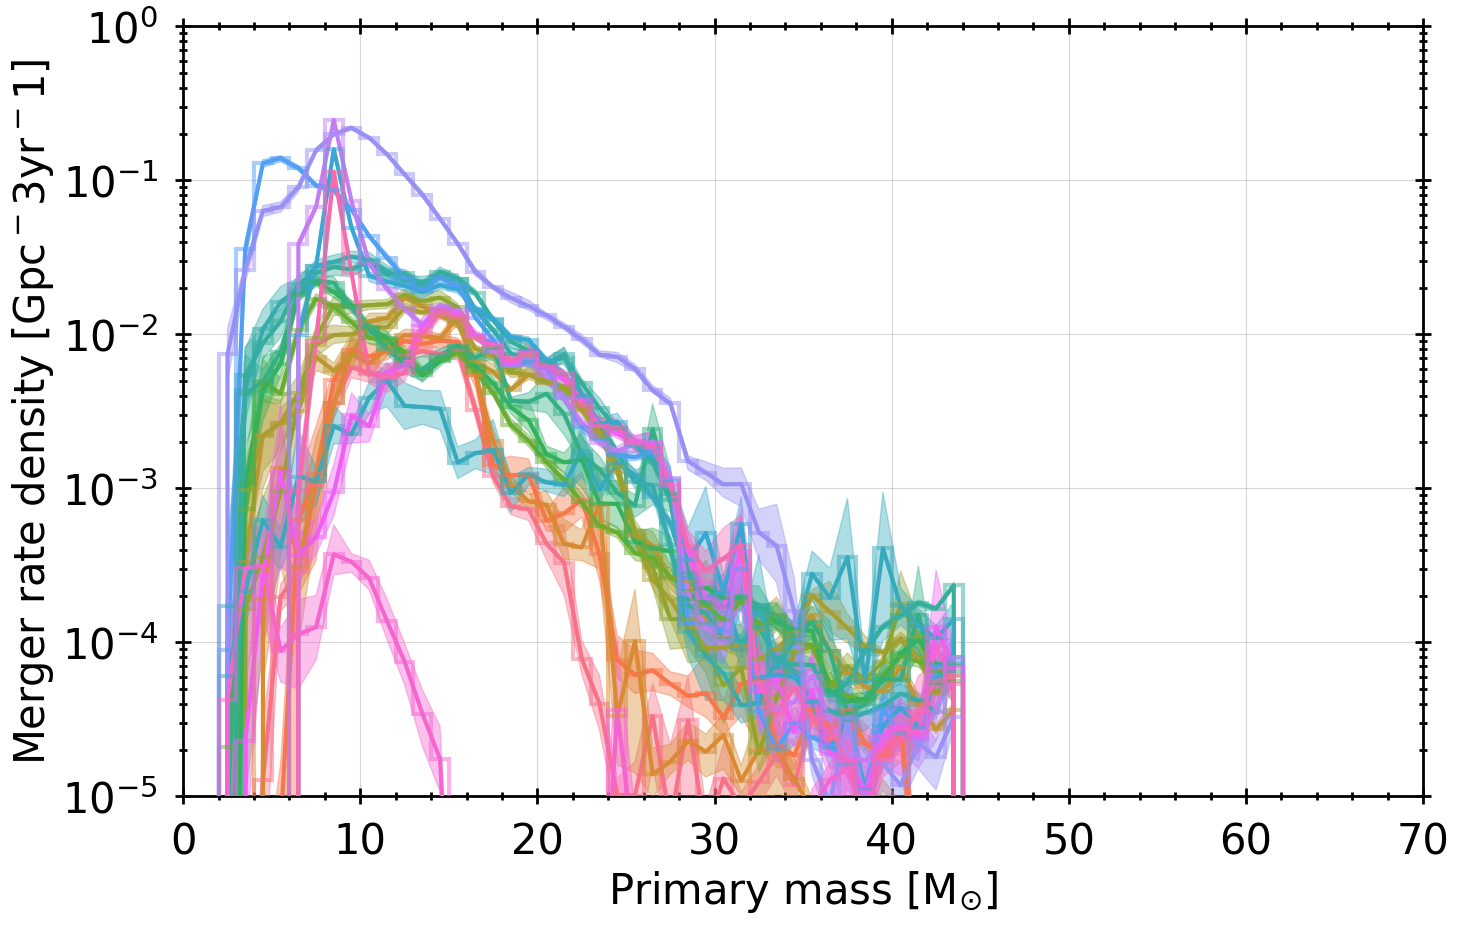

In [41]:
from syntheticstellarpopconvolve.usecase_notebook_utils.usecase_gw_utils import add_confidence_interval_powerlaw_peak_primary_mass, run_bootstrap, plot_bootstrapped_data
import seaborn as sns

colors = sns.color_palette("husl", len(boesky_dataset_list))


fig, ax = plt.subplots(figsize=(16,10))

primary_mass_bins = np.arange(0, 80, 1)
primary_mass_bin_centers = (primary_mass_bins[1:]+primary_mass_bins[:-1])/2

# make mega plot ! 
for ind_d, dataset in enumerate(boesky_dataset_list[:]):
    color_d = colors[ind_d]
#     output_hdf5_folder = 
    output_hdf5_filename = os.path.join(get_folder_path_convolution_output(growl_catalog, "Boesky24", dataset), "sspc_output.h5")
    mass_primary, yield_data = read_primary_mass_and_yields(growl_catalog, "Boesky24", dataset, output_hdf5_filename, redshift_key="0.125")



    # perform bootstrapping of the convolution results
    median_percentile_data = run_bootstrap(
        bins=primary_mass_bins,
        bin_centers=primary_mass_bin_centers,
        rates=yield_data,
        masses=mass_primary.value,
        bootstraps=50,
        verbose=False)

    # plot the data
    plot_bootstrapped_data(
        fig=fig,
        ax=ax,
        bin_centers=primary_mass_bin_centers,
        bin_edges=primary_mass_bins,
        median_percentile_data=median_percentile_data,
        label='test',
        color_i=color_d,
        linestyle_i="solid",
        include_hist_step=True
    )

# # Add confidence interval of observations (GWTC-3).
# fig, ax = add_confidence_interval_powerlaw_peak_primary_mass(
#     fig=fig,
#     ax=ax,
#     data_root=os.path.join(os.environ["DATAFILES_ROOT"], "GW"),
#     fill_between_kwargs={},
#     add_text=True,
#     redshift=0.2,
# )

# Set axis labels and title
ax.set_xlabel('Primary mass [{}]'.format(u.Msun.to_string("latex_inline")))
ax.set_ylabel(r'Merger rate density [$\rm{Gpc}^-3 \rm{yr}^-1$]')
# ax.set_ylabel('Merger rate density\n[{}]'.format(unit_dict['yield'].to_string("latex_inline")))
# ax.set_title('Merger rate density of\nmerging binary black holes at z=0')
ax.set_ylim(0.00001, 1)
ax.set_xlim(0, 70)
ax.set_yscale('log')

plt.show()



### Set underlying S(Z,z) [Example - you can skip this]- the one that describes the true Universe

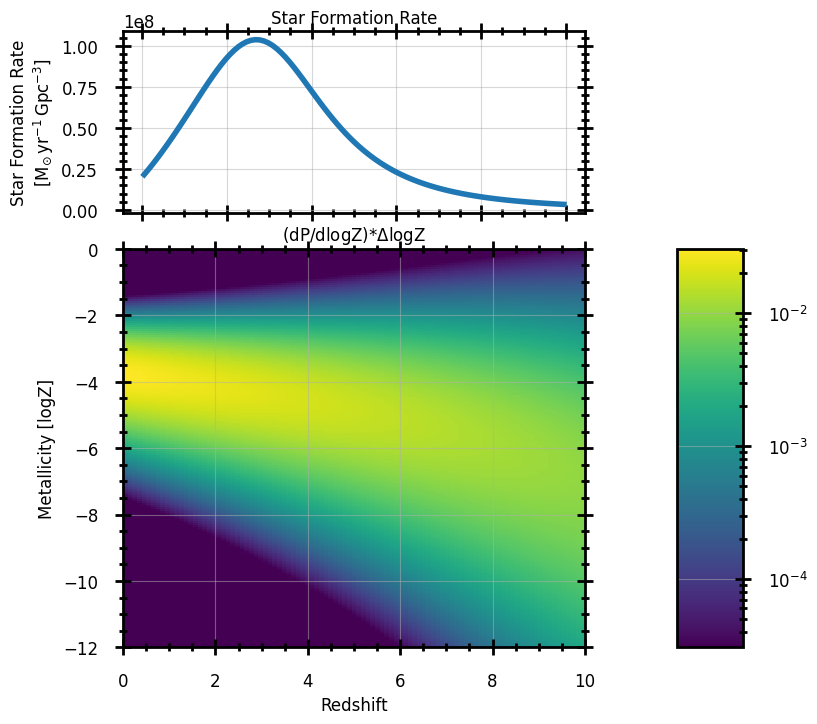

In [4]:




# Set up redshift bin info
num_redshift_bins = 100
redshift_bin_edges = np.linspace(0, 10, num_redshift_bins); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

# Set up metallicity bin info
num_metallicity_bins = 200
log_metallicity_bin_edges = np.linspace(-12, 0, num_metallicity_bins); log_metallicity_bin_centers = calculate_bincenters(log_metallicity_bin_edges)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

high_res_sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": log_metallicity_bin_edges,
    "metallicity_distribution_array": dpdlogZ,
}

axis_dict = plot_sfr_dict(
    high_res_sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)



### Set up required S(Z,z) - the one that is needed for the Simulation parameter space

we do not need to know or track S(Z,z) for the Metallicity and redshift rate that fall outside what we are interested in, or that fall outside the COMPAS metallicity range (as we will calculate weights for each COMPAS binary) 

### see note 1 at the bottom 


##### note 2
Instead of using the SSPC example where we define the log metallicity bins based on sorting the unique metallicities, we isntead
read in the metallicities from the simulation, to understand what range of metallicity bins we want to use. 
This is helpful to do as some data (Adam's) has random Metallicities sampled, so the sorting would take forever. 

In the future we can probably do this direct though (calculate the S(Z,z) weights for each individual binary) 

In [7]:


# build the GROWL catalog (only need to do this once)
growl_catalog = build_growl_catalog()


# then for each simulation: 
# calculate the metallicity range
## read in the metallicities from the simulations, to understand what range of metallicity bins we want to use 

full_path = get_file_path(growl_catalog, "Boesky24", dataset="alpha0_1beta0_5")
df = pd.read_hdf(full_path, key="input_data")

nbins=200
metallicities = df["metallicity"].values
_, log_metallicity_bin_edges = np.histogram(np.log(metallicities), bins=nbins, density=True) # the weights dont matter - we just want to get bin_centers
log_metallicity_bin_centers = (log_metallicity_bin_edges[0:-1] + log_metallicity_bin_edges[1:])/2

print(min(metallicities), max(metallicities))

0.0001000001190803619 0.023315130630088447


(1e-05, 1)

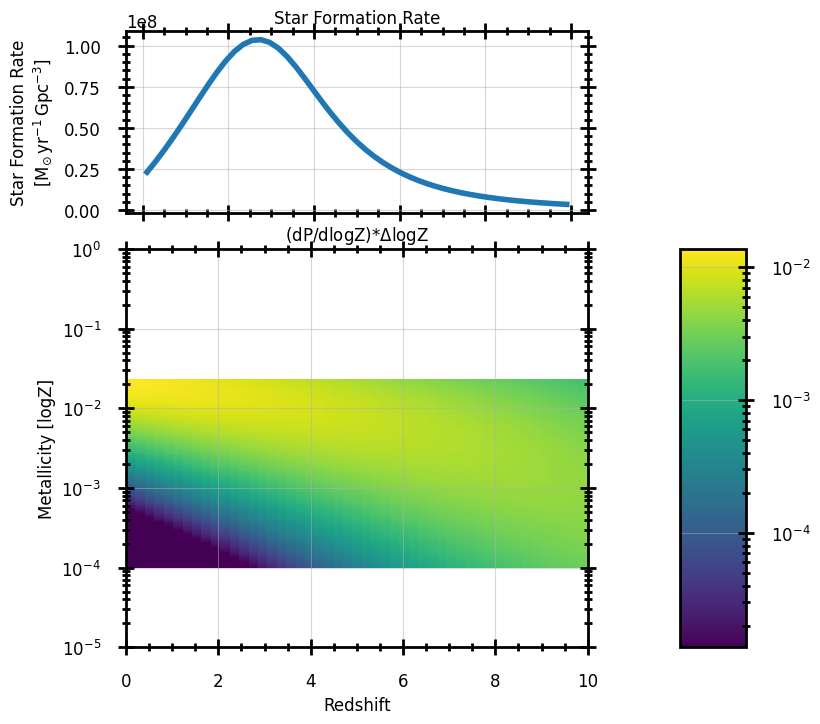

In [10]:
### Set  up S(Z,z) for this simulation, and plot it:


# convert
metallicity_bin_centers = np.exp(log_metallicity_bin_centers)
metallicity_bin_edges = np.exp(log_metallicity_bin_edges)

# Set up redshift bin info
num_redshift_bins = 50
redshift_bin_edges = np.linspace(0, 10, num_redshift_bins); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

#
sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": metallicity_bin_edges,
    "metallicity_distribution_array": ((1/metallicity_bin_centers) * dpdlogZ),  # We need to transpose!
}

axis_dict = plot_sfr_dict(
    sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)
axis_dict['ax_mssfr'].set_yscale('log')
axis_dict['ax_mssfr'].set_ylim([0.00001, 1])




/Volumes/GROWL/GROWL_bps_compact/Boesky24/alpha0_1beta0_5/


### Note
note to myself: need to check what we do with the S(Z,z) that falls outside of this range! Do we assume those are not simulated by COMPAS ? Or do we re-normalize S(Z,z) for COMPAS

In [ ]:


# # now get the output folder for the specific simulation

# output_hdf5_folder = get_folder_path_convolution_output(growl_catalog, "Boesky24", dataset="alpha0_1beta0_5")
# print(output_hdf5_folder)



# # Create instance of output
# output_hdf5_filename = os.path.join(output_hdf5_folder, "sspc_output.h5")



# generate_boilerplate_outputfile(output_hdf5_filename)


# # SET UP and copy Minimun required data from simulation

# full_path = get_file_path(growl_catalog, "Boesky24", dataset="alpha0_1beta0_5")
# df = pd.read_hdf(full_path, key="input_data")


# example_data = {
#     "delay_time": df['delay_time'].values,
#     "metallicity": df["metallicity"].values,
#     "number_per_solar_mass_values": df['formation_efficiency_per_solar_mass'].values,
# }
# example_df = pd.DataFrame.from_records(example_data)
# example_df.to_hdf(output_hdf5_filename, key="input_data/growl")



# # Some general configuration
# convolution_config = copy.copy(default_convolution_config)
# convolution_config['logger'].setLevel(logging.WARNING)
# # convolution_config["output_filename"] = output_hdf5_filename
# # convolution_config["tmp_dir"] = output_hdf5_folder
# convolution_config["redshift_interpolator_data_output_filename"] = os.path.join(
#     output_hdf5_folder, "interpolator_dict.p"
# )
# convolution_config["multiply_by_time_binsize"] = False
# convolution_config["time_type"] = "redshift"

# convolution_config["output_filename"] = output_hdf5_filename

# # convolution instructions
# convolution_config["convolution_instructions"] = [
#     {
#         **default_convolution_instruction,
#         "convolution_type": "integrate",
#         "input_data_name": "growl",
#         "output_data_name": "intrinsic",
#         "data_column_dict": {
#             # required
#             "normalized_yield": "number_per_solar_mass_values",
#             "delay_time": {"column_name": "delay_time", "unit": u.Myr},
#             "metallicity": "metallicity"
#         },
#     },
# ]

# # configure the target convolution times. In this case we only want to model the rate at redshift ~0, so its a simple set up
# convolution_config["convolution_redshift_bin_edges"] = np.array([0, 0.25])

# # store
# convolution_config["SFR_info"] = sfr_dict



# # run the convolution (main function)
# # run convolution 
# convolve(config=convolution_config)


# #done! 



### run convolution

In [ ]:
# # from syntheticstellarpopconvolve.general_functions import extract_unit_dict, print_hdf5_structure

# # # we are interested in the primary mass distribution. lets extract the primary mass values:
# # # example_usecase_GW_events_data['primary_mass'] = example_usecase_GW_events_data[['mass_1', 'mass_2']].max(axis=1)
# # # primary_mass_array = example_usecase_GW_events_data['primary_mass'].to_numpy()

# # # primary_mass, secondary_mass


# # # read out content and integrate until today
# with h5py.File(convolution_config["output_filename"], "r") as output_hdf5_file:

#     # lets inspect the structure within 'output_data'
#     print_hdf5_structure(output_hdf5_file, subkey='output_data')

#     # lets select the key
#     key = "output_data/growl/intrinsic/convolution_results/0.125/"

#     # extract the data and the unit dictionary
# #     print(output_hdf5_file['output_data']['example']['intrinsic']['convolution_results'].keys())
#     yield_data = output_hdf5_file[key+'yield'][()]
#     unit_dict = extract_unit_dict(output_hdf5_file, key)

In [ ]:
# output_hdf5_filename = os.path.join(output_hdf5_folder, "sspc_output.h5")
# print(output_hdf5_file)

In [ ]:
## read in the metallicities from the simulation, to understand what range of metallicity bins we want to use 



In [ ]:
import matplotlib.pyplot as plt
from syntheticstellarpopconvolve.usecase_notebook_utils.usecase_gw_utils import add_confidence_interval_powerlaw_peak_primary_mass, run_bootstrap, plot_bootstrapped_data

primary_mass_bins = np.arange(0, 80, 2)
primary_mass_bin_centers = (primary_mass_bins[1:]+primary_mass_bins[:-1])/2

# read in the primary masses from the original data set (not the copied one)
full_path = get_file_path(growl_catalog, "Boesky24", dataset="alpha0_1beta0_5")
df = pd.read_hdf(full_path, key="input_data")
print(df.columns)

mass_primary, mass_secondary = get_primary_secondary(df['dco_mass_1'].values, df['dco_mass_2'].values)
print(mass_primary)


##################
# Plot data
fig, ax = plt.subplots(figsize=(20,8))

# Plot histogram of primary masses and their associated rates
# ax.hist(primary_mass_array, bins=primary_mass_bins, weights=yield_data, edgecolor='black', alpha=0.7)

# perform bootstrapping of the convolution results
median_percentile_data = run_bootstrap(
    bins=primary_mass_bins,
    bin_centers=primary_mass_bin_centers,
    rates=yield_data,
    masses=mass_primary.value,
    bootstraps=50,
    verbose=False)

# plot the data
plot_bootstrapped_data(
    fig=fig,
    ax=ax,
    bin_centers=primary_mass_bin_centers,
    bin_edges=primary_mass_bins,
    median_percentile_data=median_percentile_data,
    label='test',
    color_i="black",
    linestyle_i="solid",
    include_hist_step=True
)

# # Add confidence interval of observations (GWTC-3).
# fig, ax = add_confidence_interval_powerlaw_peak_primary_mass(
#     fig=fig,
#     ax=ax,
#     data_root=os.path.join(os.environ["DATAFILES_ROOT"], "GW"),
#     fill_between_kwargs={},
#     add_text=True,
#     redshift=0.2,
# )

# Set axis labels and title
ax.set_xlabel('Primary mass [{}]'.format(u.Msun.to_string("latex_inline")))
ax.set_ylabel('Merger rate density\n[{}]'.format(unit_dict['yield'].to_string("latex_inline")))
# ax.set_title('Merger rate density of\nmerging binary black holes at z=0')
ax.set_ylim(0.00001, 1)
ax.set_xlim(0, 70)
ax.set_yscale('log')

plt.show()



### Note 1: Or if you want to see that we are not really evolving most metallicities with Population Synthesis:

In [ ]:


# convert
metallicity_bin_centers = np.exp(log_metallicity_bin_centers)
metallicity_bin_edges = np.exp(log_metallicity_bin_edges)

# Set up redshift bin info
num_redshift_bins = 50
redshift_bin_edges = np.linspace(0, 10, num_redshift_bins); redshift_bin_centers = calculate_bincenters(redshift_bin_edges)

#
dpdlogZ = metallicity_distribution_vanSon2022(
    log_metallicity_centers=log_metallicity_bin_centers,
    redshifts=redshift_bin_centers,
)

#
sfr = starformation_rate_distribution_vanSon2023(redshift_bin_centers).to(u.Msun/u.yr/u.Gpc**3)

#
sfr_dict = {
    "redshift_bin_edges": redshift_bin_edges,
    "starformation_rate_array": sfr,
    "metallicity_bin_edges": metallicity_bin_edges,
    "metallicity_distribution_array": ((1/metallicity_bin_centers) * dpdlogZ),  # We need to transpose!
}

axis_dict = plot_sfr_dict(
    sfr_dict,
    time_type="redshift",
    metallicity_string="logZ",
    metallicity_distribution_multiply_by_metallicity_bin_sizes=True,
    metallicity_distribution_multiply_by_sfr=False,
    metallicity_distribution_scale="log10",
    metallicity_distribution_cmap=copy.copy(plt.cm.viridis),
    return_axis_dict=True,
    figsize=(8,8),
    fontsize=12,
)
axis_dict['ax_mssfr'].set_yscale('log')
axis_dict['ax_mssfr'].set_ylim([0.000000000001, .1])


